In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\\..'))
	print(os.getcwd())
except:
	pass


 # Historic Trueskill Modeling

In [1]:
# Set up environment
import models
from models import TSModel
import tbapy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid', color_codes=True)
import time
import pickle
import os

tba = tbapy.TBA(os.environ['TBA_API_KEY'])


 ## Training the model
 We can now train the model on a range of years. I've already built the
 MatchData files for all the relevant years, so we can import them one by one
 and train the model on the full year of data. To train on the full range of
 data takes upwards of 20 minutes.

In [2]:
# Multi-year simulation
years = range(2005, 2020)
teams = models.get_teams(years)
model = TSModel(teams, env=models.ts.setup(mu=1000,sigma=100,beta=100,tau=10,draw_probability=.01), logging=True)

print(f"Training on {','.join(map(str, years))}")
print('='*35)
start = time.time()
winners = []

for year in years:
    filename = f"../data/{year}_MatchData_ol.csv"
    data = pd.read_csv(filename)
    data = models.process_data(data)
    data = models.sort_data(data)
    winners.append(data.winner)

    print(f"Year: {year}")
    print(f"Simulating {len(data)} matches")
    substart = time.time()

    data.apply(model.train, axis=1)

    print(f"Training time: {int(time.time() - substart)} s")
    print("=" * 35)

    #model.export(f"data/{year}_end_ratings.csv")

print(f"Training time: {int(time.time() - start)} s")
print(f"Brier score ovr: {model.test(pd.concat(winners))}")

model.rank()
model.table.head(10)


Training on 2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Year: 2005
Simulating 2068 matches
Training time: 20 s
Year: 2006
Simulating 3184 matches
Training time: 40 s
Year: 2007
Simulating 3564 matches
Training time: 60 s
Year: 2008
Simulating 4038 matches
Training time: 56 s
Year: 2009
Simulating 4658 matches
Training time: 59 s
Year: 2010
Simulating 5567 matches
Training time: 85 s
Year: 2011
Simulating 6312 matches
Training time: 88 s
Year: 2012
Simulating 7707 matches
Training time: 114 s
Year: 2013
Simulating 8242 matches
Training time: 118 s
Year: 2014
Simulating 10663 matches
Training time: 153 s
Year: 2015
Simulating 11810 matches
Training time: 172 s
Year: 2016
Simulating 13286 matches
Training time: 239 s
Year: 2017
Simulating 15429 matches
Training time: 291 s
Year: 2018
Simulating 16930 matches
Training time: 333 s
Year: 2019
Simulating 18022 matches
Training time: 298 s
Training time: 2135 s
Brier score ovr: 0.1997674490299037


,Rating,Score,Rank
Team,,,
3707,"trueskill.Rating(mu=1512.335, sigma=62.182)",890.517763,1.0
3538,"trueskill.Rating(mu=1484.647, sigma=62.056)",864.088722,2.0
254,"trueskill.Rating(mu=1638.306, sigma=77.479)",863.520105,3.0
1678,"trueskill.Rating(mu=1511.668, sigma=66.851)",843.162559,4.0
2056,"trueskill.Rating(mu=1556.855, sigma=71.509)",841.762347,5.0
1323,"trueskill.Rating(mu=1525.765, sigma=68.655)",839.212906,6.0
2767,"trueskill.Rating(mu=1519.120, sigma=68.310)",836.023924,7.0
5406,"trueskill.Rating(mu=1419.096, sigma=62.135)",797.744899,8.0
2910,"trueskill.Rating(mu=1491.414, sigma=69.410)",797.316537,9.0


 ## Testing
 It's important to ensure that our tests are meaningful - particularly, they
 should mirror the actual use case of our model. In this case, we want to use
 our fully trained model to predict a match outcome before it happens. To this
 effect, we test by importing the 2018 model and training it on the 2019 season
 once again and recording our predictions. Then we find the Brier score of
 those predictions against the actual results. All of this is handled by the
 model's `train()` and `test()` methods, with logging enabled.

In [3]:
# Test with 2019 data
YEAR = 2019
trainedmodel = TSModel(logging=True)
trainedmodel.load(f"data/{YEAR-1}_end_ratings.csv")

data = pd.read_csv(f"../data/{YEAR}_MatchData_ol.csv")
data = models.process_data(data)
data = models.sort_data(data)

print(f"Year: {YEAR}")
print(f"Simulating {len(data)} matches")
substart = time.time()

data.apply(trainedmodel.train, axis=1)

print(f"Training time: {int(time.time() - substart)} s")
print("=" * 35)

print(f"Brier score: {trainedmodel.test(data.winner)}")


Year: 2019
Simulating 18022 matches
Training time: 312 s
Brier score: 0.20609438513991013


 We can also assess our model by looking at the distribution of skill across
 all FRC teams. Here we show the distribution of score for all teams which
 played matches in 2019.

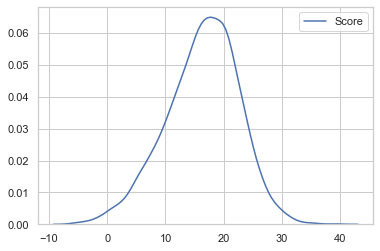

In [4]:
model = TSModel(logging=True)
model.load("data/2019_end_ratings.csv")
sns.kdeplot(model.table.loc[model.table.Score != 0,'Score'])
plt.show()


 We can also visualize ratings by graphing the mean ($\mu$) against the
 standard deviation ($\sigma$) of each team. Interestingly, we see in the lower
 left that the teams trail off toward the higher $\mu$ values, with low
 $\sigma$. Upon closer examination, we can see that these teams are all the
 well-recognized powerhouse teams - in this chart, we actually have a visual
 representation of the best teams in FRC.

c:\Users\Sam\Documents\236\Statistics\Analytics\trueskill_demo.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


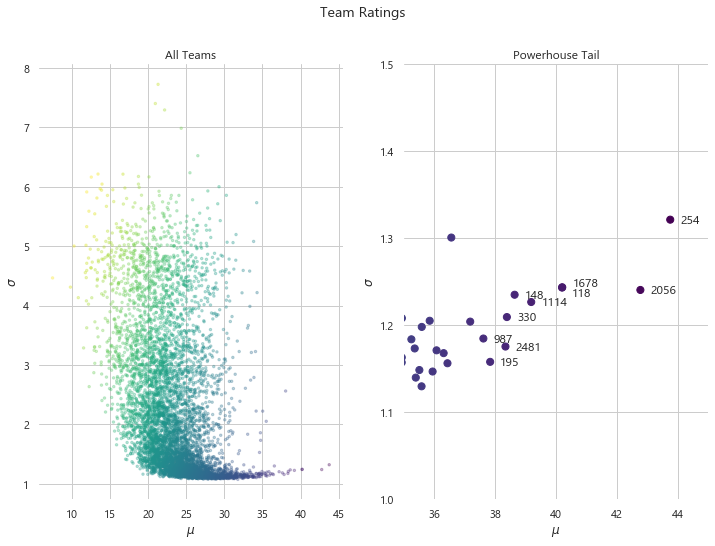

In [5]:
# Plot with matplot
filtered = model.table.loc[model.table.Score != 0]
pairs = list(map(tuple, filtered.Rating))
x,y = zip(*pairs)
z = filtered.Score
t = list(filtered.index)

plt.rcParams['image.cmap'] = 'viridis_r'
plt.rcParams['font.family'] = 'Segoe UI'

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,8))
fig.suptitle("Team Ratings")

ax1.scatter(x,y,c=z, alpha=0.3, s=6)

ax1.set_title("All Teams")
ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$\sigma$')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.scatter(x,y,c=z, alpha=1.0, s=50)

ax2.set_title("Powerhouse Tail")
ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$')

for i,txt in list(enumerate(t))[:10]:
    offy=-4
    if txt == 1678:
        offy=1
    elif txt == 118:
        offy=-9
    ax2.annotate(txt, (x[i],y[i]),(10,offy), textcoords='offset pixels')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.set_xlim(35,45)
ax2.set_ylim(1,1.5)

fig.show()


In [6]:
# Prediction demo
def match_teams(match_key):
    match = tba.match(key=match_key, simple=True)

    blue = [int(t[3:]) for t in match.alliances['blue']['team_keys']]
    red = [int(t[3:]) for t in match.alliances['red']['team_keys']]

    return (blue,red)

match_key = "2019cmpmi_f1m1"
blue, red = match_teams(match_key)
print(f"Match: {match_key}")
print(f"Blue: {blue}")
print(f"Red: {red}")
print(f"Blue win probability: {model.predict(blue, red):.3%}")
print(f"Match quality: {model.quality(blue, red):.3%}")


Match: 2019cmpmi_f1m1
Blue: [217, 3707, 4481]
Red: [930, 5406, 1310]
Blue win probability: 55.128%
Match quality: 99.992%


 We can also calculate the rating of an alliance by adding together the
 distributions for each team on the alliance. Naturally, we sum the variance as
 well to produce a skill rating for each alliance, which we can compare to rank
 the Einstein finalists.

In [7]:
# Rank finalist alliances
alliances = {
    'arc': (5406,930,1310,4004),
    'tes': (346,548,5401,2534),
    'cars': (5050,111,4607,2052),
    'dar': (3707,217,4481,1218),
    'cur': (195,3538,1073,230),
    'dal': (4003,133,862,2614)
}

ratings = pd.DataFrame(
    {
        'Alliance':list(alliances.keys()),
        'Rating':[model.rate_alliance(a) for a in list(alliances.values())]
    }
)

ratings['Score'] = ratings.Rating.apply(model.env.expose)
ratings.sort_values('Score', ascending=False)
ratings


,Alliance,Rating,Score
0,arc,"trueskill.Rating(mu=122.173, sigma=8.638)",96.259711
1,tes,"trueskill.Rating(mu=120.634, sigma=8.619)",94.776288
2,cars,"trueskill.Rating(mu=126.683, sigma=8.657)",100.712933
3,dar,"trueskill.Rating(mu=126.039, sigma=8.632)",100.144587
4,cur,"trueskill.Rating(mu=134.646, sigma=8.632)",108.751413
5,dal,"trueskill.Rating(mu=127.495, sigma=8.622)",101.629696
